<a href="https://colab.research.google.com/github/swahareddy/TA-GCC-2019/blob/master/Indian_News_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome!

Vision: 

Proposed solution:
1. Get news article info from some API/ RSS/ HomePage web-scraping
2. Write relevant metadata from the response into DB
3. Follow the link to actual article and scrape content
4. Use GCP Nat Lang  API to get sentiment from this scraped content
5. Use GCP to asssign category to the article
5. Write to DB
6. Visualise from DB

In order for this project to have any use, it must be based upon a dataset that is alive (and not just an old source from Kaggle)

## This MVP does:
1. Get news article info from [newsapi.org](https://)
2. Use GCP Nat Lang  API to get sentiment
3. Use [GCP Content Classification](https://cloud.google.com/natural-language/docs/classify-text-tutorial)
3. Write this data into a database (bigquery)
3. Simple visualisation 

Do not get intimidated by all the google stuff (bigquery, nat lang APIs, colab etc) that is being used here. I have **personally written an intro** for you here. Please check it out - https://docs.google.com/document/d/13uFHIBOyLlUpG_pqfvrTX__9fI5yskZvhr6_B_7ViKY/edit?usp=sharing

GCP- Google cloud platform, BQ - bigQuery

## Task Board

### Fresh work:
* Get categories - DONE
* Sync google drive for local storage
* API reseasrch
* Start web scraping 
* Create DB - DONE
* Database modificatons
  * Better pkey needed (avoid recurring rows)
  * Add link column to DB
* How do I make the job recurring
  * Extend colab timeout
  * Create cron job
* Stream into google sheets to automate visualisation
 
### Tweak logic:
  * Add more exciting news sources to API 
  * Why are there null sources
  * Clean up author name based on syntax
  * Add more Indian sources
  Is databse name parameterised?



### Current DB Structure
p_id,
Publish time,
Write time,
Author,
Source,
Update time,
Title,
Description,
Content,
Sentiment score,
Sentiment magnitude,
Category 1 name,
Category 1 confidence,
Category 2 name,
Category 2 confidence,
Category 3 name,
Category 3 confidence

______
Ignore the follwoing GCP authentication cell for now:



In [23]:
# Setting up connection with GCP
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "maybe-well-do-something-d7263a30102e.json"
project_id="maybe-well-do-something"

# Open BigQuery connection
# !pip install google-cloud-bigquery
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

def run_bq(query):
  query_job = client.query(query)
  results = query_job.result() 
  return results

## Getting latest articles from [newsapi.org](https://)

Note for alternative APIs:
* Going back in history is something I would definitely want to do and not just start data from when this app is deployed.
* [This](https://ucrawler.app/) is sexy. The user can intuitively create their own standard RSS source for whatever website. Allows for **historical data** access!? 
Don't need to limit to news alone, can add blogs etc too.
Has a free plan that allows upto 3 sources per person (but what about RSS fee?ds)
* [This](https://https://webhose.io/news-api/united-kingdom-news-api) offers historical data at a cheap rate
____
The following cell asks for latest 20 articles from each of the 'domains'. It recieves a JSON in response:

In [24]:
import requests
import pprint
# url = ('http://newsapi.org/v2/top-headlines?'
#        'country=in&'
#        'apiKey=04bb8b8233b348c68003408e02b07443')
# response = requests.get(url)
# pprint.pprint(response.json())
domains=['thehindu.com',
         'hindustantimes.com',
         'techcrunch.com',
         'thenextweb.com'
        ]
api_results={}
for domain in domains:
  url = ('http://newsapi.org/v2/everything?'
        'domains='+domain+'&'
        'apiKey=04bb8b8233b348c68003408e02b07443')
  response = requests.get(url)
  json_response=response.json()
  pprint.pprint(json_response)
  api_results[domain]=json_response

# https://newsapi.org/v2/everything?domains=techcrunch.com,thenextweb.com&apiKey=04bb8b8233b348c68003408e02b07443

{'articles': [{'author': 'Special Correspondent',
               'content': 'Rane Holdings Ltd, (RHL) the holding company of the '
                          'Rane Group, reported a 77% drop in its net profit '
                          'before exceptional items to 73.7 crore for the '
                          'fourth quarter ended March 2020 on lower volumes a… '
                          '[+1638 chars]',
               'description': 'Board declares final dividend of ₹4',
               'publishedAt': '2020-06-24T17:15:25Z',
               'source': {'id': 'the-hindu', 'name': 'The Hindu'},
               'title': 'Rane Holdings Q4 net profit plunges 77%',
               'url': 'https://www.thehindu.com/business/rane-holdings-q4-net-profit-plunges-77/article31909006.ece',
               'urlToImage': 'https://www.thehindu.com/static/theme/default/base/img/og-image.jpg'},
              {'author': 'The Hindu',
               'content': 'NLC India Ltd., a Navratna company under the Coal

## GCP function definition to calculate sentiment

Takes string as input

Returns dictionary, Eg: sentiment_out={'Sentiment_mag': 0.20000000298023224, 'Sentiment_score': -0.20000000298023224}

In [25]:
from google.cloud import language_v1
from google.cloud.language_v1 import enums

def sample_analyze_sentiment(text_content):
    client = language_v1.LanguageServiceClient()
    # Available types: PLAIN_TEXT, HTML
    type_ = enums.Document.Type.PLAIN_TEXT

    document = {"content": text_content, "type": type_}
    encoding_type = enums.EncodingType.UTF8 # Available values: NONE, UTF8, UTF16, UTF32
    response = client.analyze_sentiment(document, encoding_type=encoding_type)

    # Get overall sentiment of the input document
    print(u"Document sentiment score: {}".format(response.document_sentiment.score))
    print(
        u"Document sentiment magnitude: {}".format(
            response.document_sentiment.magnitude
        )
    )

    '''
    for sentence in response.sentences:
        print(u"Sentence text: {}".format(sentence.text.content))
        print(u"Sentence sentiment score: {}".format(sentence.sentiment.score))
        print(u"Sentence sentiment magnitude: {}".format(sentence.sentiment.magnitude))
    '''

    print(u"Language of the text: {}".format(response.language))
    sentiment_output={'Sentiment_score':response.document_sentiment.score,
                      'Sentiment_mag':response.document_sentiment.magnitude}
    # print (sentiment_output)
    return sentiment_output

# GCP function definition to identify relevant categories
Takes string as input (in 20 words)

Returns dictionary like {'/Sports/Team Sports/Cricket': 0.949999988079071, '/Law & Government/Government': 0.6100000143051147, '/News/Sports News': 0.5199999809265137}

These are the various possible categories - https://cloud.google.com/natural-language/docs/categories (Overall 700+, but we can bother only with high level categories that are a handful)

In [78]:
# Get category realted to text
from google.cloud import language

from itertools import islice
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

def classify(text, verbose=True):
    language_client = language.LanguageServiceClient()

    document = language.types.Document(
        content=text,
        type=language.enums.Document.Type.PLAIN_TEXT)
    response = language_client.classify_text(document)
    categories = response.categories

    result = {}

    for category in categories:
        result[category.name] = category.confidence

    # if verbose:
        # print(text)
        # for category in categories:
            # print(u'=' * 20)
            # print(u'{:<16}: {}'.format('category', category.name))
            # print(u'{:<16}: {}'.format('confidence', category.confidence))

    return dict(result.items())

# print(classify("Sabiha Bhoomigowda, the outgoing Vice-Chancellor of Karnataka State Akkamahadevi Women’s University, said that she was happy to have completed some of the dream projects of the university during her t"))

{'/Jobs & Education/Education/Colleges & Universities': 0.7599999904632568}


In [105]:
# Main function to add entries into the databse
# Takes all article information as input, does not return anything

# Converts JSON's timestamp into format compatible with BQ DB 
def break_time(in_time):
  # input 2020-06-24T17:09:04Z
  # output (2008, 12, 25, 05, 30, 00)
  date, time = in_time.split('T')
  year, month, day = date.split('-')
  hour, min, sec = time[:-1].split(':')
  return "DATETIME("+year+", "+month+", "+day+", "+hour+", "+min+", "+sec+")"

# Remove problematic characters before writing to database
def clean_text(string):
  if string is not None:
    return string.replace("’", "").replace("\n", "").replace("\r", "").replace("\"", "").replace("“", "").replace("”", "").replace("'", "")
  else:
     return ""

def write_to_bq(article, sent_score, sent_mag, article_categories_info):

  '''
  The 'article' variable passed to this function has structure like this dictionary:
  {'source': {'id': 'the-hindu', 'name': 'The Hindu'}, 
  'author': 'Special Correspondent', 
  'title': 'ICC chairman: Board meets on Thursday to finalise process', 
  'description': 'The International Cricket Council (ICC) Board is set to meet on Thursday to finalise the process of electing Shashank Manohar’s successor as the ICC chairman. The issue has been on the agenda for the', 
  'url': 'https://www.thehindu.com/sport/cricket/icc-chairman-board-meets-on-thursday-to-finalise-process/article31908898.ece', 
  'urlToImage': 'https://www.thehindu.com/static/theme/default/base/img/og-image.jpg', 
  'publishedAt': '2020-06-24T17:09:04Z', 
  'content': 'The International Cricket Council (ICC) Board is set to meet on Thursday to finalise the process of electing Shashank Manohars successor as the ICC chairman. \r\nThe issue has been on the agenda for th… [+742 chars]'}
  '''

  # get latest primary key to understand new key
  get_max_id_query="select max(id) from news_data_main.news_master";
  latest_id=(list(run_bq(get_max_id_query))[0][0])
  print (latest_id)
  if latest_id is None:
    latest_id=0
  print (latest_id)
  p_id=latest_id+1

  print (article)
  source=clean_text(article['source']['id'])
  author=clean_text(article['author'])
  title=clean_text(article['title'])
  description=clean_text(article['description'])
  content=clean_text(article['content'])
  publish_ts=break_time(article['publishedAt'])

  if len(article_categories_info)>0:
    Identified_category_1_name = str(article_categories_info[0]['name'])
    Identified_category_1_probability = str(article_categories_info[0]['value'])
    if len(article_categories_info)>1:
      Identified_category_2_name = str(article_categories_info[1]['name'])
      Identified_category_2_probability = str(article_categories_info[1]['value'])
    else:
      Identified_category_2_name = ""
      Identified_category_2_probability = "0"        
  else:
    Identified_category_1_name = ""
    Identified_category_1_probability = "0"
    Identified_category_2_name = ""
    Identified_category_2_probability = "0"  
  #   values(225, 'the-hindu', 'Special Correspondent', 'Rane Holdings Q4 net profit plunges 77%', 'Board declares final dividend of ₹4', 'Rane Holdings Ltd, (RHL) the holding company of the Rane Group, reported a 77% drop in its net profit before exceptional items to 73.7 crore for the fourth quarter ended March 2020 on lower volumes a… [+1638 chars]', DATETIME(2020, 06, 24, 17, 15, 25), 0.0, 0.0, , 0, , 0, CURRENT_DATETIME(), CURRENT_DATETIME())

  values=str(p_id)+", '"+source+"', '"+author+"', '"+title+"', '"+description+"', '"+content+"', "+publish_ts+", "+str(sent_score)+", "+str(sent_mag)+", '"+Identified_category_1_name+"', "+Identified_category_1_probability+", '"+Identified_category_2_name+"', "+Identified_category_2_probability+", CURRENT_DATETIME(), CURRENT_DATETIME()"
  insert_immediate_data_query="Insert into news_data_main.news_master (id, Source, Author, Title, Description, Content, Publish_time, Sentiment_score, Sentiment_magnitude, Identified_category_1_name, Identified_category_1_probability, Identified_category_2_name, Identified_category_2_probability, Original_write_time, Update_time) values("+values+")"

  run_bq(insert_immediate_data_query)

# All processing happens through the following code cell:

In [106]:
sources_information={}
# For each news source:
for source in api_results.keys():
  sources_information[source]={'total_sentiment':0,
                               'total_magnitude':0,
                               'no_of_articles':len(api_results[source]['articles']),
                               'categories':[]}
  
  print ("Number of articles by "+source+" is "+str(len(api_results[source]['articles']))+"\n")
  json_response=api_results[source]
  # For each article for a particular news source
  for article in json_response['articles']:
      categories_info=[]
      # if (article['description'] is not None) and (article['content'] is not None):
      #   print (str(len(article['description']))+" "+str(len(article['content'])))
      # Surprisingly the 'description' of the article is longer than 'content' in JSON
      text_content=article['description']
      print (text_content)

      # Get sentiment score and magnitude . Understand meaning of this at https://cloud.google.com/natural-language/docs/basics#interpreting_sentiment_analysis_values
      # Eg: sentiment_out={'Sentiment_mag': 0.20000000298023224, 'Sentiment_score': -0.20000000298023224}
      sentiment_out=sample_analyze_sentiment(text_content)

      # Handle categories, see all possible categories at https://cloud.google.com/natural-language/docs/categories
      # Eg: {'/Sports/Team Sports/Cricket': 0.949999988079071, '/Law & Government/Government': 0.6100000143051147, '/News/Sports News': 0.5199999809265137}
      article_categories_info=[]
      if len(text_content.split())>20: # Minimum number of words for content classification
        categories_info=classify(text_content) # Returns 2 relevant categories and their confidence scores
        print (categories_info)
        if len(categories_info)>0:
          categories_info=categories_info.items()
          
          for category_info in categories_info:

            article_category_info={'name':"", 'value':""}
            article_category_info['name']=category_info[0]
            article_category_info['value']=category_info[1]
            article_categories_info.append(article_category_info)

            # <--COMMENT All lines between this and the next comment are for getting  matplotlib visualisation data, can be IGNORED
            category_string=category_info[0]
            split_categories=category_string[1:].split('/')
            if len(split_categories)!=1:
              split_categories=[category_string[1:]]+split_categories
            for split_category in split_categories:
              if split_category not in sources_information[source]['categories']:
                sources_information[source]['categories']=sources_information[source]['categories']+split_categories
                print (sources_information[source]['categories'])      

      sources_information[source]['total_sentiment']=sources_information[source]['total_sentiment']+sentiment_out['Sentiment_score']
      sources_information[source]['total_magnitude']=sources_information[source]['total_magnitude']+sentiment_out['Sentiment_mag']
      # COMMENT-->

      # Write all information to database 
      write_to_bq(article, sentiment_out['Sentiment_score'], sentiment_out['Sentiment_mag'], article_categories_info)


      print ()

  print ("-------------------------------------------------------------------------")


Number of articles by thehindu.com is 20

Board declares final dividend of ₹4
Document sentiment score: 0.0
Document sentiment magnitude: 0.0
Language of the text: en
None
0
{'source': {'id': 'the-hindu', 'name': 'The Hindu'}, 'author': 'Special Correspondent', 'title': 'Rane Holdings Q4 net profit plunges 77%', 'description': 'Board declares final dividend of ₹4', 'url': 'https://www.thehindu.com/business/rane-holdings-q4-net-profit-plunges-77/article31909006.ece', 'urlToImage': 'https://www.thehindu.com/static/theme/default/base/img/og-image.jpg', 'publishedAt': '2020-06-24T17:15:25Z', 'content': 'Rane Holdings Ltd, (RHL) the holding company of the Rane Group, reported a 77% drop in its net profit before exceptional items to 73.7 crore for the fourth quarter ended March 2020 on lower volumes a… [+1638 chars]'}

NLC India Ltd., a Navratna company under the Coal Ministry, has posted a 35.28% growth in its standalone net profit for the fourth quarter ended March 2020 to ₹392.48 crore. T

# Visualisation Ideas

End state - DataStudio/ Tableau/ Looker...

*   I would imagine the actual UI to show comparative overall sentiment for 10 default news websites.
*   A drop down to select the domain sentiment (and show mean and median of an average domain 
*   A drop down to select the journalist's sentiment (and show mean and median of an average journalist) 
*   A full text search to show aggregate sentiment for the articles where your keyword occurs.
*   For both, the news website and the journalist, we should also show variance (how consistent is their sentiment) 
*   For all this you should be able to select a date range, and we can show time series of sentiment.
______
______

## Quick fix UI: (Not built yet)

Prequisites: GCP basics, Node.js (.gs file appears to be similar), Spreadsheets

The BigQuery database feeds into a Google Sheet (on demand).
This can update the sheet that has preset formulae for formatting and visualisations ([See example](https://blog.sheetgo.com/how-to-solve-with-sheetgo/how-to-get-data-from-bigquery-to-google-sheets-automatically/))
___
This pipeline is possible based on intructions [here](https://https://blog.sheetgo.com/how-to-solve-with-sheetgo/how-to-get-data-from-bigquery-to-google-sheets-automatically/) [[demo script](https://docs.google.com/spreadsheets/d/1KfQJcnLUjzMRBsYCcmCAVBQzsAuXnTXfv9SjaCiTQug/edit?usp=sharing)] , but needs proper modifications to connect (probably using credential.json) to connect to our BQ table
___
___

## Python visualisations:

Just plotting some graphs (on aggregate sentiment data for each source) to make sense of the data.

{'thehindu.com': -1.7000000104308128, 'hindustantimes.com': -3.800000138580799, 'techcrunch.com': -2.2000000551342964, 'thenextweb.com': -3.6000000312924385}
{'thehindu.com': 5.1000000461936, 'hindustantimes.com': 5.700000159442425, 'techcrunch.com': 10.300000190734863, 'thenextweb.com': 19.10000006109476}


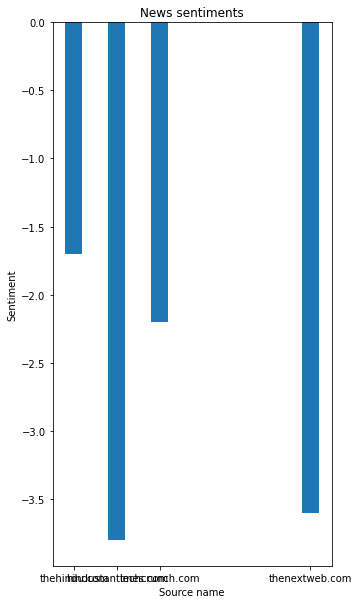

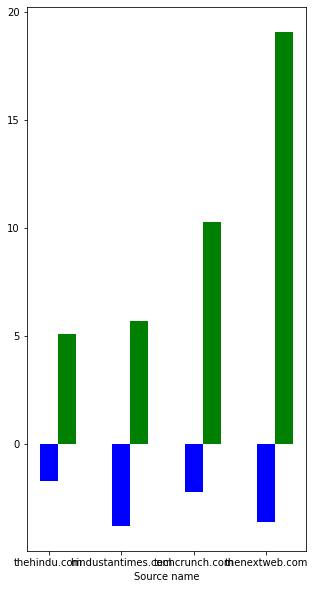

In [ ]:
print (total_sentiment)
print (total_magnitude)

import numpy as np
import matplotlib.pyplot as plt 

# Need to scale the scores

# x-coordinates of left sides of bars  
left = [1, 3, 5, 12] 

# heights of bars 
height = list(total_sentiment.values())

# labels for bars 
tick_label = list(total_sentiment.keys())

# plotting a bar chart 
plt.bar(left, height, tick_label = tick_label, width = 0.8) 

# naming the x-axis 
plt.xlabel('Source name') 
# naming the y-axis 
plt.ylabel('Sentiment') 
# plot title 
plt.title('News sentiments') 
# function to show the plot 
plt.show() 


data=[list(total_sentiment.values()),list(total_magnitude.values())]
# print (data)
plt.xlabel('Source name') 
X = np.arange(4)

tick_label = list(total_sentiment.keys())
plt.bar(X + 0, data[0], color = 'b', width = 0.25, tick_label = tick_label)
plt.bar(X + 0.25, data[1], color = 'g', width = 0.25)

plt.show()

## Possible extensions:

Ranking news sources by how left or right wing they are.
How would we do this:
Prerequiste - 
* Define a right and left wing corpus that those wings like to be associated with 
  * This can automated into its own project


  


Note: *These projects assumes that all articles are created equal, which may not be the case. Since in reality some articles are promoted, some are given banner space on home page while others are relegated to some depth of the website.*

Could we get some kind of weight for articles? We'd have to do our own web scraping for listening to new articles from website instead of relying on API
Read up on how the source News API itself gets article info 